# Optical Music Recognition - Staff Removal
In this Notebook we are going to download the CVC Muscima Dataset, and try to do staff removal, using the ground truth provided in the dataset.
We are going to use Tensorflow as our backend.

## What is Staff Removal?
Staff Removal is one of the very early steps of preprocessing

In [ ]:
!pip install requests

# for gpu, without cuda
!pip install tensorflow
# for gpu, with cuda
# !pip install tensorflow[and-cuda]
!pip install pillow

In [2]:
import requests
import os
import zipfile
import shutil
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image

2025-05-27 19:07:08.826202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 19:07:08.839928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 19:07:08.839954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 19:07:08.849376: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 19:07:09.347067: W tensorflow/compiler/tf

In [3]:
# Convenience Functions

# For sanity Checking of the Hyperparams in cfg make sense
def find_largest_image_resolution(root, valid_extensions = [".png"]):
    max_resolution = (0, 0)
    max_image_path = None

    folder_paths = os.listdir(root)
    # probably mac residuals, not a folder
    folder_paths = remove_macos(folder_paths)

    for folder_path in folder_paths:
        for root, _, files in os.walk(os.path.join(root, folder_path)):
            for file in files:
                if os.path.splitext(file)[1].lower() in valid_extensions:
                    image_path = os.path.join(root, file)
                    try:
                        with Image.open(image_path) as img:
                            width, height = img.size
                            if width * height > max_resolution[0] * max_resolution[1]:
                                max_resolution = (width, height)
                                max_image_path = image_path
                    except Exception as e:
                        print(f"Error reading {image_path}: {e}")

    return max_resolution, max_image_path

# Helper function to remove residuals from zipping
def remove_macos(dir_cont: list) -> list:
    if ".DS_Store" in dir_cont:
        dir_cont.remove(".DS_Store")
    return dir_cont

# Directory crawler for creating data/target file paths.
def crawler(data_root: str = "data", target_root: str = "target") -> tuple[tf.Tensor, tf.Tensor]:
    data_dir = remove_macos(
        sorted(
            os.listdir(data_root)
        )
    )
    target_dir = remove_macos(
        sorted(
            os.listdir(target_root)
        )
    )
    
    data = []
    targets = []

    if not (data_dir == target_dir):
        raise ValueError(f"Content of the directories not identical.\nContent of Data: {data_dir}\nContent of Target: {target_dir}")
    
    for dir in data_dir:
        if os.path.isdir(os.path.join(data_root, dir)) and os.path.isdir(os.path.join(target_root, dir)):
            # grab the contents of both directories
            data_dir_cont = remove_macos(
                sorted(
                    os.listdir(
                        os.path.join(data_root, dir)
                    )
                )
            )
            target_dir_cont = remove_macos(
                sorted(
                    os.listdir(
                        os.path.join(target_root, dir)
                    )
                )
            )

            if data_dir_cont == target_dir_cont:

                # extend the file names to full paths
                data_dir_cont = [
                    os.path.join(data_root, dir, file) for file in data_dir_cont
                ]

                target_dir_cont = [
                    os.path.join(target_root, dir, file) for file in target_dir_cont
                ]

                data.extend(data_dir_cont)
                targets.extend(target_dir_cont)
                
            else:
                raise Exception(f"Contents of data and target do not match.\nData: {data_dir_cont}\nTarget: {target_dir_cont}")
        else:
            raise Exception(f"Not a directory: {dir} in {data_root}.")
    
    return tf.convert_to_tensor(data, dtype = tf.string), tf.convert_to_tensor(targets, dtype = tf.string)


def visualize_images(
        images, 
        titles = None, 
        vmin = -1, 
        vmax = 1
    ):

    n = len(images)
    titles = titles or [f"Image {i+1}" for i in range(n)]

    fig, ax = plt.subplots(1, n, figsize = (5 * n, 5))

    if n == 1:
        ax = [ax]  # ensure ax is iterable

    for i, (img, axis) in enumerate(zip(images, ax)):
        # Convert to numpy and squeeze singleton dims
        img = tf.squeeze(img)
        img = img.numpy() if isinstance(img, tf.Tensor) else img

        axis.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        axis.set_title(titles[i])
        axis.axis('off')

    fig.tight_layout()
    fig.show()

In [ ]:
# Downalad an unzip dataset
def download_extract_zip(filename, extract_to):
    try:
        url = "http://datasets.cvc.uab.es/muscima/CVCMUSCIMA_WI.zip"
        response = requests.get(url, stream = True)
        response.raise_for_status()
        
        # Download
        if os.path.exists(filename) and os.path.getsize(filename) >= 984118102:
            print("File exists and is of correct size (or bigger)")
        else:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size = 8192):
                    f.write(chunk)
            print(f"Downloaded {filename}")

        # Extract
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted {filename} to {extract_to}")

        # The zip contains a __MACOSX folder with thumbnails...
        shutil.rmtree(
            os.path.join(
                extract_to,
                "__MACOSX"
                )
            )        
        # Make folder structure more accessible
        for filename in os.listdir(os.path.join(extract_to, 'CVCMUSCIMA_WI')):
            shutil.move(
                os.path.join(extract_to, 'CVCMUSCIMA_WI', filename),
                os.path.join(extract_to, filename)
            )
        os.rmdir(os.path.join(extract_to, 'CVCMUSCIMA_WI'))

        # We want to train on Grayscale Images, not on Black/White
        shutil.rmtree(
            os.path.join(
                extract_to,
                "PNG_GT_BW"
                )
            )  
    
    except Exception as e:
        print(f"Failed to download {filename}: {e}")

@tf.function
def load_and_preprocess(
        data_path: tf.Tensor, 
        target_path: tf.Tensor,
        width: int = 1280,
        height: int = 720
    ):
    # Read and decode images
    data_img = tf.io.read_file(data_path)
    data_img = tf.io.decode_png(
        contents = data_img,
        channels = 1,
        dtype = tf.uint8
    )
    # Invert, since resice_with_pad fills pad with 0s
    data_img = tf.uint8.max - data_img
    
    # No Inversion of target, since the file is 0 (background) and 255 (Notes)
    target_img = tf.io.read_file(target_path)
    target_img = tf.io.decode_png(
        contents = target_img, 
        channels = 1,
        dtype = tf.uint8
    )

    # Resize
    data_img = tf.image.resize_with_pad(
        image = data_img,
        target_height = height,
        target_width = width,
        # Not using Anti-Aliasing makes the model perform worse 
        # and the input image a lot more incoherent 
        antialias = True
        )
    # Revert
    data_img = tf.uint8.max - data_img

    target_img = tf.image.resize_with_pad(
        image = target_img,
        target_height = height,
        target_width = width,
        antialias = True
        )
    # And make target similar to Data (255 = Background)
    target_img = tf.uint8.max - target_img

    data_img = tf.cast(
        x = data_img, 
        dtype = tf.float32
        )
    target_img = tf.cast(
        x = target_img,
        dtype = tf.float32
    )

    # Shift to [-1, 1]
    data_img = data_img / 127.5 - 1
    target_img = target_img / 127.5 - 1

    return data_img, target_img

def create_dataset(
        data_paths: tf.Tensor, 
        target_paths: tf.Tensor, 
        img_width: int = 1280,
        img_height: int = 720,
    ) -> tf.data.Dataset:

    dataset = tf.data.Dataset.from_tensor_slices((data_paths, target_paths))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess(
                data_path = x, 
                target_path = y, 
                width = img_width, 
                height = img_height
            ),
        num_parallel_calls = tf.data.AUTOTUNE
    )

    return dataset

## Define Hyperparameter
The image resolution, and the low batch size are stemming from my low-VRAM (8GB) GPU. Adjust these to make it better on your system

In [5]:
cfg = {
    "path": "data",
    "img_width": int(3479 / 4),
    "img_height": int(2466 / 4),
    "batch": 8,
    "shuffle_buffer": 2,
    "epochs": 5
}

## Downloading the dataset
The CVC-Muscima dataset is downloaded in the current working directory as `cvc.zip` and extracted to `./data`.

### Regarding Splits
Standard would be splitting the dataset into training and testing - if not also validation - sets. However, this requires to load the full dataset into memory, and this is not possible on many systems with low to mid (maybe even high) capacity (tested with 32GB). This is mainly because the images are pretty high-resolution.

In [6]:
# Known, but no fix: Executing this function twice leads to unexpected results (Folders in Folders)
# download_ext((tashtiract_zip("cvc.zip", "data")

# Checking if our image dimensions make sense
print(find_largest_image_resolution("data/PNG_GT_Gray"))
# Sanity Check, should equal the other
print(find_largest_image_resolution("data/PNG_GT_NoStaff"))

data, target = crawler(
        data_root = os.path.join("data", "PNG_GT_Gray"),
        target_root = os.path.join("data", "PNG_GT_NoStaff")
    )
ds = create_dataset(
    data_paths = data,
    target_paths = target,
    img_width = cfg["img_width"],
    img_height = cfg["img_height"],
)

ds = ds.shuffle(cfg["shuffle_buffer"]).batch(cfg["batch"]).prefetch(tf.data.AUTOTUNE)

((3479, 2466), 'data/PNG_GT_Gray/w-23/p017.png')
((3479, 2466), 'data/PNG_GT_NoStaff/w-23/p017.png')


2025-05-27 19:07:10.147026: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 19:07:10.180774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-27 19:07:10.182908: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Model Definition
Below a Model with 3 CNN layers is defined. To see how it would look like with e.g. a fourth layer, uncomment the code. \
The decreasing kernel size with increasing network depth is inspired by https://doi.org/10.1007/978-3-319-58838-4_31. Or paper [51]

In [7]:
inputs = keras.Input(
    shape = (cfg["img_height"], cfg["img_width"],1),
    batch_size = cfg["batch"],
    dtype = tf.float32
    )
x = keras.layers.Conv2D(
        filters = 16,
        kernel_size = 10,
        strides = 1,
        padding = "same",
        activation = "tanh"
    )(inputs)
# x = keras.layers.Conv2D(
#         filters = 32,
#         kernel_size = 5,
#         strides = 1,
#         padding = "same",
#         activation = "tanh"
#     )(x)
x = keras.layers.Conv2D(
        filters = 64,
        kernel_size = 3,
        strides = 1,
        padding = "same",
        activation = "tanh"
    )(x)
out = keras.layers.Conv2D(
        filters = 1,
        kernel_size = 3,
        strides = 1,
        padding = "same",
        activation = "tanh"
    )(x)

model = keras.Model(
    inputs = inputs,
    outputs = out
)
model.compile(
    optimizer = "adam",
    loss = "mse",
    # metrics = ["accuracy"]
)
model.summary()
#

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (8, 616, 869, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 616, 869, 16)      │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 616, 869, 64)      │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 616, 869, 1)       │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,473 (44.82 KB)

 Trainable params: 11,473 (44.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.fit(ds, epochs = cfg["epochs"])

Epoch 1/5


I0000 00:00:1748365631.501148   41063 service.cc:145] XLA service 0x7fc81010bf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748365631.501204   41063 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-05-27 19:07:11.520827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-27 19:07:11.596925: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/125 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - loss: 0.7207

I0000 00:00:1748365651.419919   41063 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 0.1310
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.0212
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.0062
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.0046
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - loss: 0.0041


Let us take a look on how good our model is by now!

2025-05-27 19:08:36.190278: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-27 19:08:36.288894: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-27 19:08:37.145736: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
/tmp/ipykernel_40949/2299790066.py:118: UserWarning: FigureCanvasAg

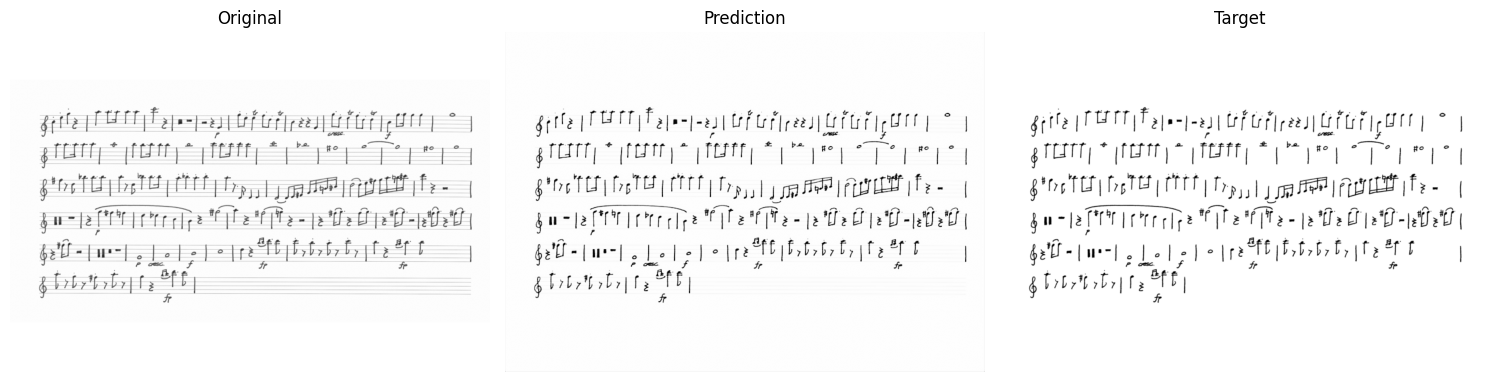

In [9]:
for x, y in ds.take(1):
    pred = model(x)
    visualize_images(
        images = [x[0], pred[0], y[0]],
        titles = ["Original", "Prediction", "Target"]
    )
